<a href="https://colab.research.google.com/github/Lyshen/PiggyToy/blob/main/Lesson03_CNN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lesson 3. Simple CNN excerise
## 1. Improve lesson 2's code
## 2. Save the usually-used code
## 3. Try to implement your simple CNN using the MNIST dataset
## 4. Compare the results between CNN and DNN
## 5. Maybe it is slow. Try to improve the speed of the SGD


In [48]:
import matplotlib.pyplot as plt
import numpy as np

def plot_features_and_labels(features, labels, size_of_class, markers, colors, title):
    plt.figure(figsize=(3,3))
    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])
    plt.title(title)
    plt.show()


def split_train_and_test_data(feature_matrix, label_matrix, split_rate = 0.9):
    m = feature_matrix.shape[0]
    split_index = int(m * split_rate)

    indices = np.array(range(m))
    np.random.shuffle(indices)

    train_indices, test_indices = np.array(indices[0:split_index]), np.array(indices[split_index:])
    train_features, train_labels = feature_matrix[train_indices, :], label_matrix[train_indices, :]
    test_features, test_labels = feature_matrix[test_indices, :], label_matrix[test_indices, :]

    return train_features, train_labels, test_features, test_labels


def draw_neuron_boundary(neuron, features, labels, markers, colors, grid_step=0.5, size_of_class= 2):
    min_x, max_x = np.min(features[:, 0]), np.max(features[:, 0])
    min_y, max_y = np.min(features[:, 1]), np.max(features[:, 1])

    xx, yy = np.meshgrid(np.arange(min_x - 1, max_x + 1, grid_step), np.arange(min_y - 1, max_y + 1, grid_step))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    predict = neuron.predict(grid_points)
    argmax_index = np.argmax(predict, axis=1)

    positive_index = grid_points[np.where(argmax_index == 0), :]
    negative_index = grid_points[np.where(argmax_index == 1), :]

    plt.figure(figsize=(4, 4))
    for i in range(size_of_class):
        class_index = grid_points[np.where(argmax_index == i), :]
        plt.scatter(class_index[0, :, 0], class_index[0, :, 1], c=colors[i], alpha=0.1)

    for i in range(size_of_class):
        x = features[np.where(labels[:, i] == 1), 0]
        y = features[np.where(labels[:, i] == 1), 1]
        plt.scatter(x, y, marker=markers[i], c=colors[i])

    plt.show()

#Exercise 1. Do a warm up exercise with double moon dataset
## 1. Design a complex multiple classes classfication problem
## 2. Try to use lesson 2's code
## 3. Improve lesson 2's code


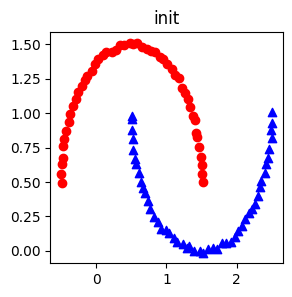

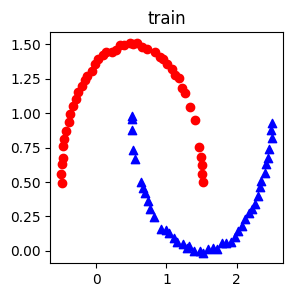

In [49]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 1
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')
#plot_features_and_labels(test_features, test_labels, size_of_class, markers, colors, 'test')

In [50]:
# Re implement simple DNN
sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))

# array / vector  very carefully
softmax = lambda a: np.exp(a) / (np.sum(np.exp(a), axis=1)[:, np.newaxis])

class Linear:
    def __init__(self, in_size, out_size = 1):
        self.in_size = in_size + 1
        self.out_size = out_size
        self.X = None
        self.W = np.random.uniform(-1., 1., size=(self.in_size, self.out_size))
        self.dL_by_dW = None

    def forward(self, X):
        self.X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = self.X.dot(self.W)
        return Z

    def backward(self, dL_by_dZ):
        # Matrix Z = XW   X(m, n+1) W(n+1, out) Z(m, out)
        # dL/dZ = (m, out) dZ/dX = W.T  (out, n+1)  dZ/dW = X.T (n+1, m)
        # dL/dW = dZ/dW * dL/dZ  (n+1, out)
        # dL/dX = dL/dZ * dZ/dX  (m, n+1)

        # backward dL/dX and record dL/dW
        dZ_by_dW = self.X.T  #(n+1, m)
        dZ_by_dX = self.W.T  #(out, n+1)
        dL_by_dX = dL_by_dZ.dot(dZ_by_dX) #(m, n+1)
        self.dL_by_dW = dZ_by_dW.dot(dL_by_dZ) #(n+1, out)
        return dL_by_dX[:, :-1]

    def predict(self, X):
        X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
        Z = X.dot(self.W)
        return Z

    def update_weights(self, learning_rate):
        self.W = self.W - self.dL_by_dW * learning_rate


class Sigmoid_Active_Function:
    def __init__(self):
        self.active_function = sigmoid
        self.H = None

    def forward(self, X):
        self.H = self.active_function(X)
        return self.H

    def backward(self, up_gradient):
        self.local_gradient = (1 - self.H) * self.H
        down_gradient = up_gradient * self.local_gradient
        return down_gradient

    def predict(self, X):
        H = self.active_function(X)
        return H

    def update_weights(self, learning_rate):
        return

class Cross_Entropy_Loss:
    def __init__(self):
        self.process_function = softmax

    def forward(self, Z, Y):
        self.Y_hat = self.process_function(Z)
        self.loss = -1. * np.sum(Y * np.log(self.Y_hat, where= self.Y_hat != 0)) #KL divergence
        return self.Y_hat, self.loss

    def backward(self, Y):
        # Math provement
        self.dL_by_dZ = self.Y_hat - Y
        return self.dL_by_dZ

In [51]:
class Operator_Packager:
    def __init__(self, operator_list):
        self.operator_list = operator_list

    def forward(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].forward(Z)
        return Z

    def backward(self, E):
        d = E
        size = len(self.operator_list)
        for i in range(size):
            index = size - 1 - i
            d = self.operator_list[index].backward(d)
        return d

    def predict(self, X):
        Z = X
        size = len(self.operator_list)
        for i in range(size):
            Z = self.operator_list[i].predict(Z)
        Y_hat = softmax(Z)
        return Y_hat

    def update_weights(self, learning_rate):
        size = len(self.operator_list)
        for i in range(size):
            self.operator_list[i].update_weights(learning_rate)


In [52]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


(90, 2)
(90, 2)


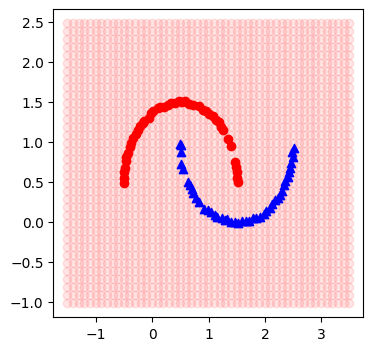

Epoch 1
-------------------------------
loss : 0.589488056235654


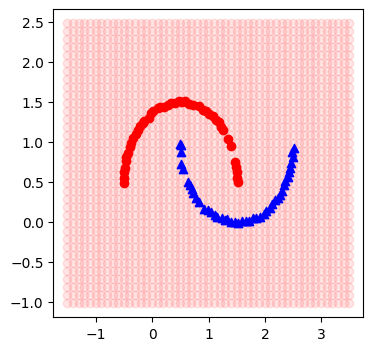

loss : 1.0866447580433456


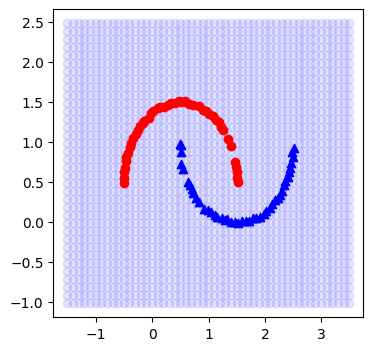

Epoch 21
-------------------------------
loss : 1.0026252704188934


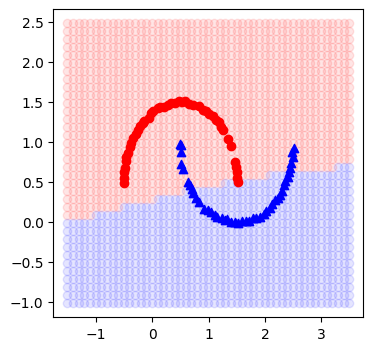

loss : 0.09710514361008685


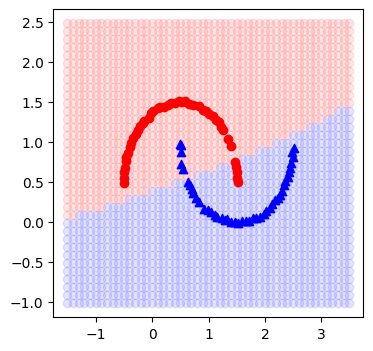

Epoch 41
-------------------------------
loss : 0.8093003176512652


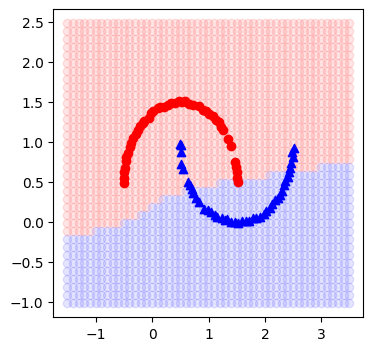

loss : 0.05814009712270502


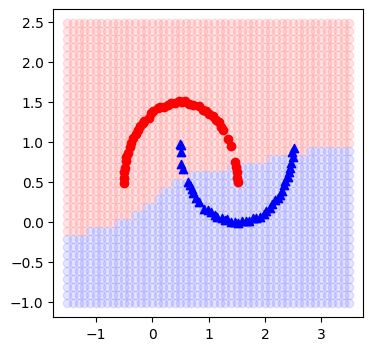

Epoch 61
-------------------------------
loss : 0.8875428056576544


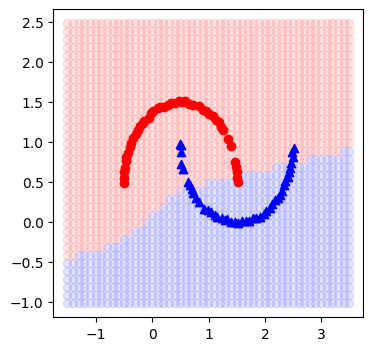

loss : 0.015436711885492858


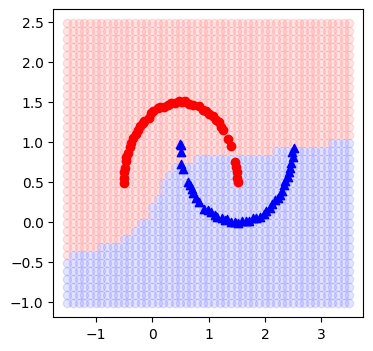

In [53]:
demo_neuron = SimpleDNN(2, 2)
loss = Cross_Entropy_Loss()

print(train_features.shape)
print(train_labels.shape)

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 20 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 20 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

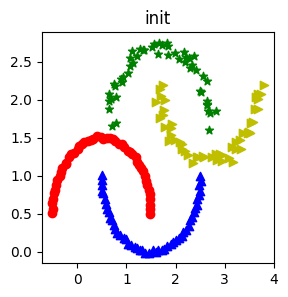

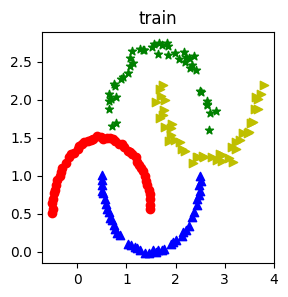

In [54]:
from sklearn.datasets import make_moons, make_circles

time_of_iter = 2
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter

markers = ['o', '^', '*', '>']
colors = ['r', 'b', 'g', 'y']
noises = [0.01, 0.06]
random_indexs = [0.5, 1.7]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [55]:
class SimpleDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 3),
            Sigmoid_Active_Function(),
            Linear(3, 3),
            Sigmoid_Active_Function(),
            Linear(3, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)


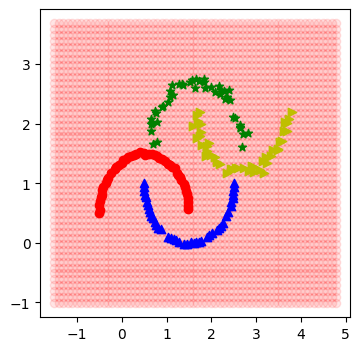

Epoch 1
-------------------------------
loss : 1.136753888104052


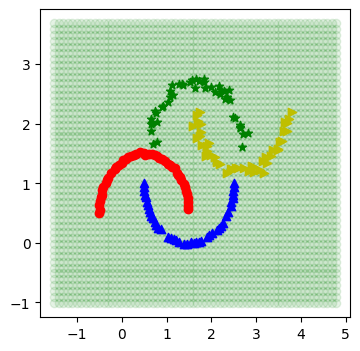

loss : 1.5283123005713497


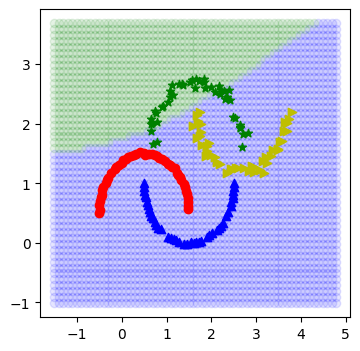

Epoch 11
-------------------------------
loss : 1.2435670122427733


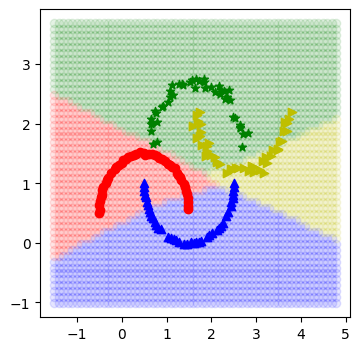

loss : 0.40657702500780923


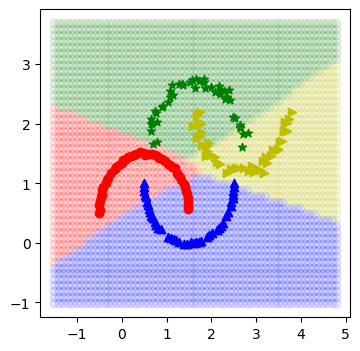

Epoch 21
-------------------------------
loss : 1.5105873638038285


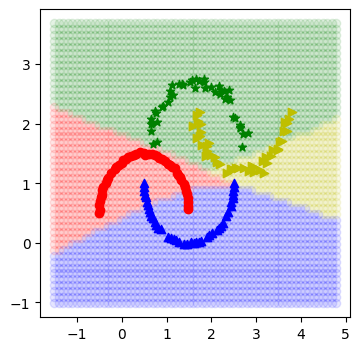

loss : 0.33726190962668023


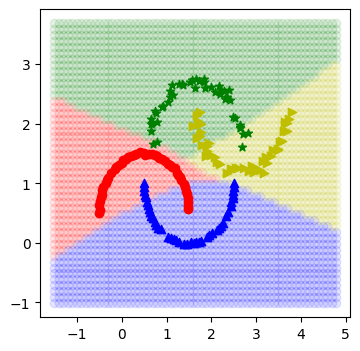

Epoch 31
-------------------------------
loss : 2.1136809180374985


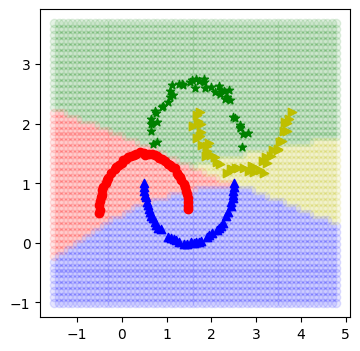

loss : 0.6433883171948283


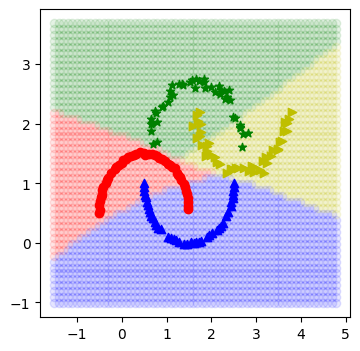

Epoch 41
-------------------------------
loss : 0.970472757722225


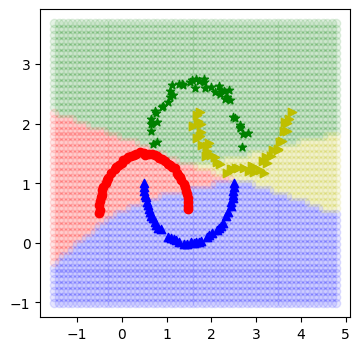

loss : 2.2012793668396817


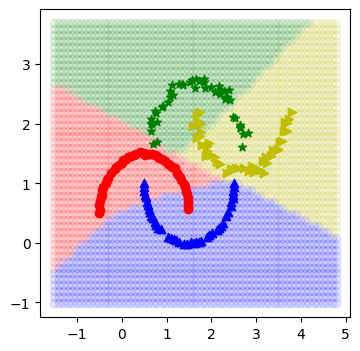

Epoch 51
-------------------------------
loss : 0.9736684840570768


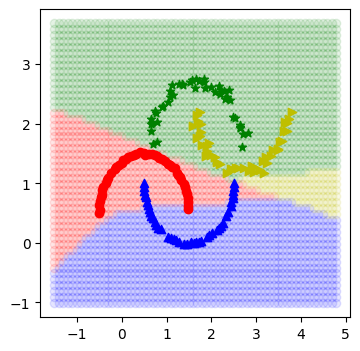

loss : 1.8713015023945612


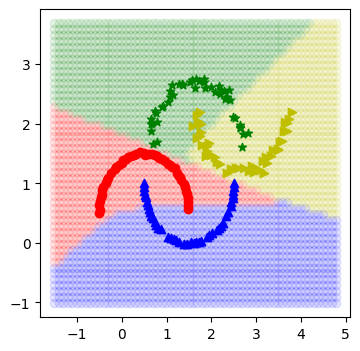

Epoch 61
-------------------------------
loss : 0.933233305126277


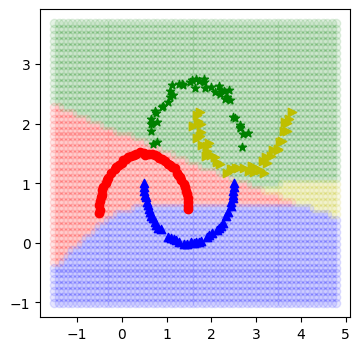

loss : 1.5675836863336878


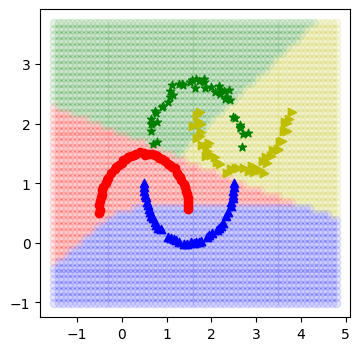

Epoch 71
-------------------------------
loss : 1.1785427818150336


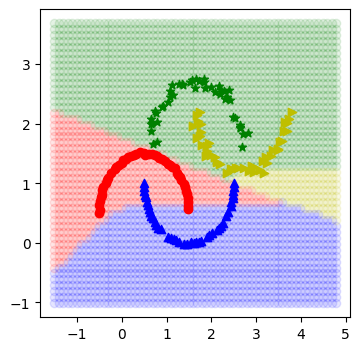

loss : 1.8957160027209774


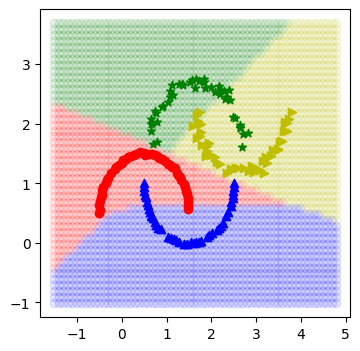

In [56]:
demo_neuron = SimpleDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 80
m = train_labels.shape[0]
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 10 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 2. Warm up exercise 2 with double moon dataset
## 1. Try to use a complex DNN to fix a multiple classes classfication problem


In [57]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, 10),
            Sigmoid_Active_Function(),
            Linear(10, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

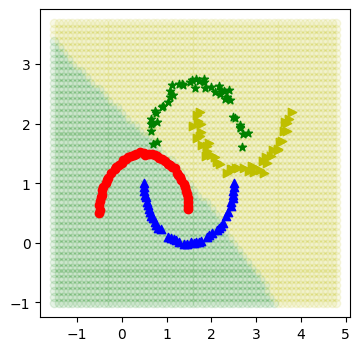

Epoch 1
-------------------------------
loss : 0.9912999005471643


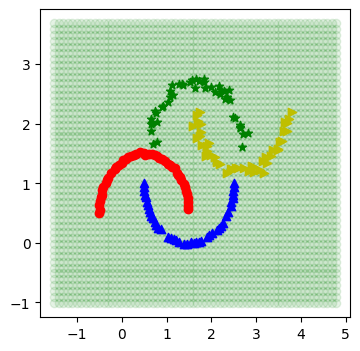

loss : 1.5245790693296903


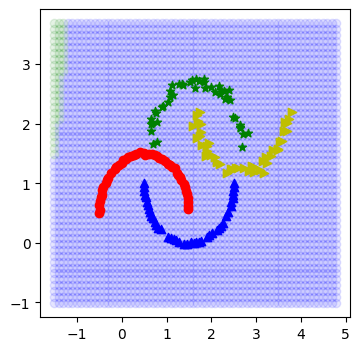

Epoch 51
-------------------------------
loss : 0.002270159857090626


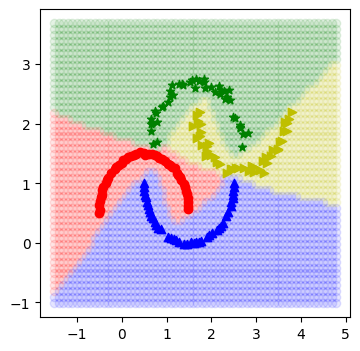

loss : 0.0016041443426772159


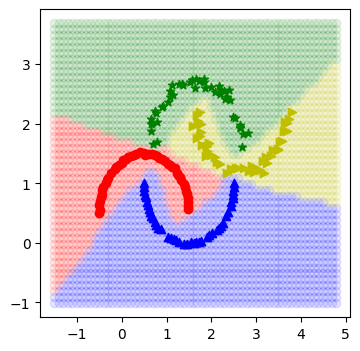

Epoch 101
-------------------------------
loss : 0.0005609585651393148


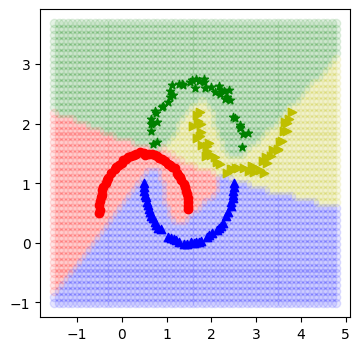

loss : 0.000414875334932484


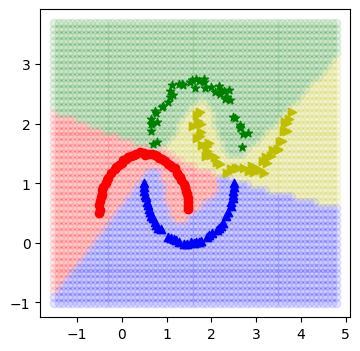

Epoch 151
-------------------------------
loss : 0.00032212672484609157


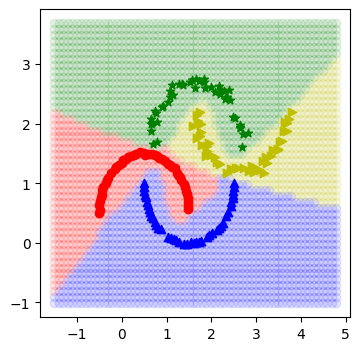

loss : 0.000239134409021693


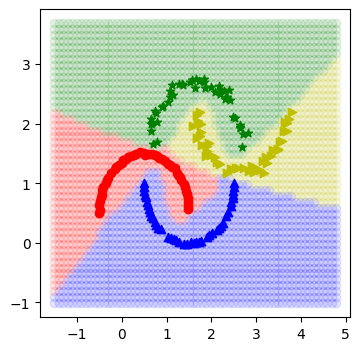

In [58]:
demo_neuron = ComplexDNN(2, 4)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 200
m = train_labels.shape[0]
for t in range(epochs):
    if t % 50 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 50 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 3: Warm up exercise 3
## 1. A more complicated multiple class classification problem


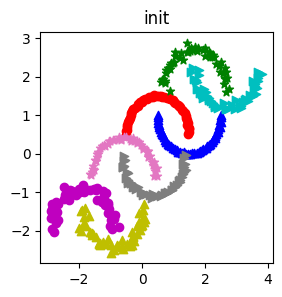

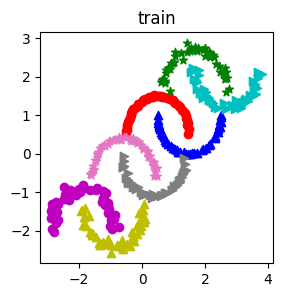

In [59]:
from sklearn.datasets import make_moons, make_circles
import matplotlib.colors as mcolors

time_of_iter = 4
size_of_sample = 100
size_of_features = 2
size_of_class = 2 * time_of_iter
#plot_colortable(mcolors.TABLEAU_COLORS, ncols=2, sort_colors=False)
markers = ['o', '^', '*', '>', 'o', '^', '*', '>', '<' ]
colors = ['r', 'b', 'g', 'c', 'm', 'y', mcolors.TABLEAU_COLORS['tab:pink'], mcolors.TABLEAU_COLORS['tab:gray'], mcolors.TABLEAU_COLORS['tab:olive']]
noises = [0.01, 0.06, 0.1, 0.04]
random_indexs = [0.5, 1.7, -1.9, -0.6]

feature_list = []
labels = np.zeros((size_of_sample * time_of_iter, size_of_class))

for i in range(time_of_iter):
    moon_features, moon_labels = make_moons(n_samples=size_of_sample, noise=noises[i])
    random_matrix = np.ones(moon_features.shape) * random_indexs[i]
    moon_features = moon_features + random_matrix

    for j in range(2):
        index = i * 2 + j
        matrix_where = i * size_of_sample + np.array(np.where(moon_labels == j))
        labels[matrix_where, index] = 1
    feature_list.append(moon_features)

features = np.concatenate(feature_list, axis=0)
train_features, train_labels, test_features, test_labels = split_train_and_test_data(features, labels)

plot_features_and_labels(features, labels, size_of_class, markers, colors, 'init')
plot_features_and_labels(train_features, train_labels, size_of_class, markers, colors, 'train')

In [60]:
class ComplexDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, 20),
            Sigmoid_Active_Function(),
            Linear(20, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

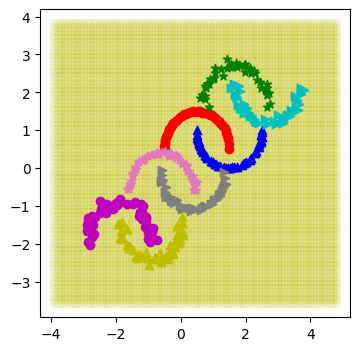

Epoch 1
-------------------------------
loss : 2.303583867402089


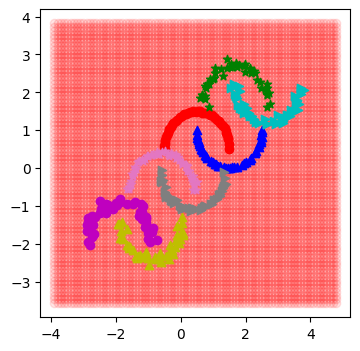

loss : 1.7309229411759477


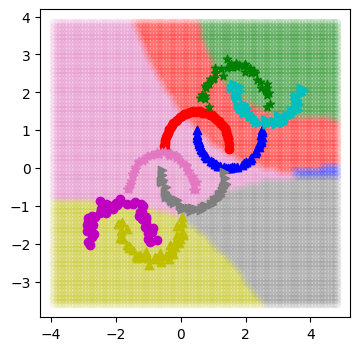

Epoch 101
-------------------------------
loss : 0.00021029280620510094


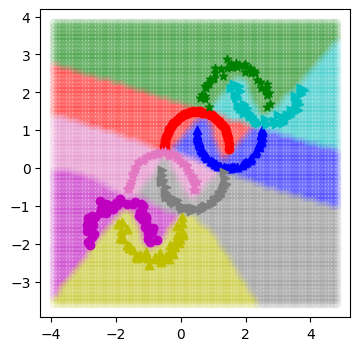

loss : 0.0026125339794524386


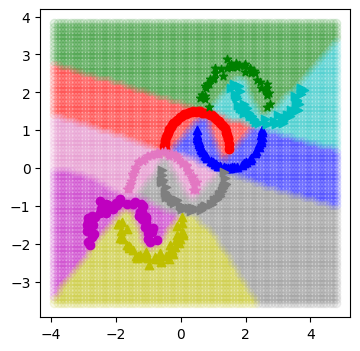

Epoch 201
-------------------------------
loss : 0.00012417347436449594


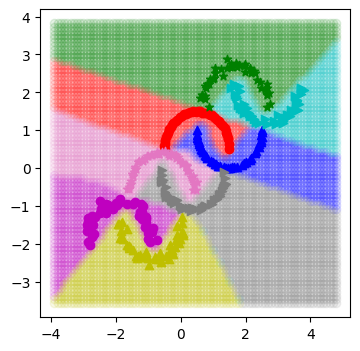

loss : 0.003543425974260603


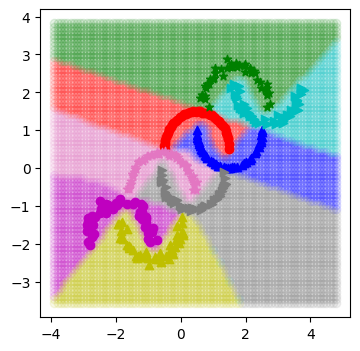

Epoch 301
-------------------------------
loss : 2.9504652482230444e-05


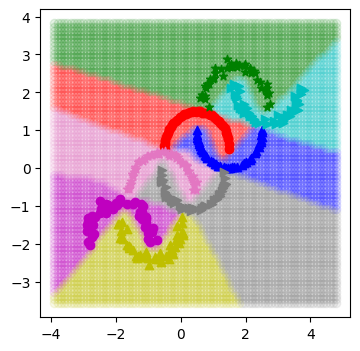

loss : 0.00046677209527026776


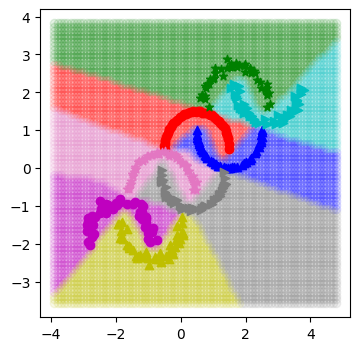

In [61]:
demo_neuron = ComplexDNN(2, 8)
loss = Cross_Entropy_Loss()

draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 400
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 100 == 0:
            print('loss :', l)
            draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

#Exercise 4: A classical experiment -- MNIST
1. Use your implement of DNN to get a baseline
2. Try to implement your simple CNN model and get the correct bp
3. Use Pytorh CNN model to compare with your own CNN in the effect and speed


In [62]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [63]:
tt = transforms.Compose([transforms.ToTensor()])

train_data = MNIST(root='./data', train=True, transform=tt, download=True)
#test_data = MNIST(root='./data', train=False, transform=tt)

torch.Size([60000, 28, 28])
torch.Size([60000])


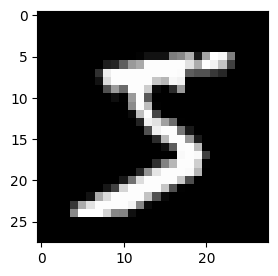

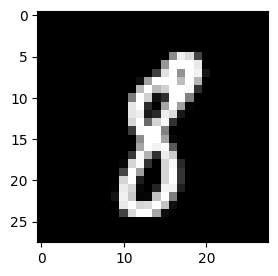

In [64]:
np_train_features = train_data.data.numpy()
np_train_labels = train_data.targets.numpy()

print(train_data.data.shape)
print(train_data.targets.shape)
#print(test_data.data.shape)
#print(test_data.targets.shape)

#print(train_data.data[0])
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[0], cmap='gray')
plt.show()
figure = plt.figure(figsize=(3, 3))
plt.imshow(np_train_features[300], cmap='gray')
plt.show()

In [65]:
import numpy as np
train_features = np.resize(np_train_features, (np_train_features.shape[0], 28 * 28))
train_labels = np.zeros((np_train_labels.shape[0], 10))
for i in range(10):
    train_labels[np.where(np_train_labels == i), i] = 1

In [66]:
print(train_features.shape)
print(train_labels.shape)
print(train_labels[0])

(60000, 784)
(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [67]:
class MnistDNN:
    def __init__(self, size_of_features, size_of_class):
        self.model = Operator_Packager([
            Linear(size_of_features, 100),
            Sigmoid_Active_Function(),
            Linear(100, 100),
            Sigmoid_Active_Function(),
            Linear(100, 100),
            Sigmoid_Active_Function(),
            Linear(100, size_of_class)
        ])

    def forward(self, X):
        Z = self.model.forward(X)
        return Z

    def backward(self, E):
        d = self.model.backward(E)
        return d

    def predict(self, X):
        return self.model.predict(X)

    def update_weights(self, learning_rate):
        self.model.update_weights(learning_rate)

In [69]:
demo_neuron = MnistDNN(28*28, 10)
loss = Cross_Entropy_Loss()

#draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

epochs = 400
m = train_labels.shape[0]
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t+1}\n-------------------------------")

    for iter_id in range(m):
        X = train_features[iter_id, :]
        Y = train_labels[iter_id, :]
        X = X.reshape((1, X.shape[0]))
        Y = Y.reshape((1, Y.shape[0]))

        Z = demo_neuron.forward(X)
        predicts, l = loss.forward(Z, Y)

        dL_by_dZ = loss.backward(Y)
        dL_by_dW = demo_neuron.backward(dL_by_dZ)

        demo_neuron.update_weights(learning_rate = 0.3)

        if iter_id % (m-1) == 0 and t % 100 == 0:
            print('loss :', l)
            #draw_neuron_boundary(demo_neuron, train_features, train_labels, markers, colors, 0.1, size_of_class)

Epoch 1
-------------------------------
loss : 9.779464143800174
loss : 14.965009019035966
loss : 8.226348331146973
loss : 21.54385487075422
loss : 7.610557015597998
loss : 21.383418952807343
loss : 12.50194052498371
loss : 4.226163093478252
loss : 18.305187704839774
loss : 9.778559268270154
loss :

<ipython-input-50-3f2d46d86fdd>:2: RuntimeWarning: overflow encountered in exp
  sigmoid = lambda a: 1.0 / (1.0 + np.exp(-a))


流式输出内容被截断，只能显示最后 5000 行内容。
loss : 2.516134313058414
loss : 3.410560290921921
loss : 2.0837277316748675
loss : 2.1275133199154697
loss : 2.1171895504088534
loss : 2.1401403015782936
loss : 1.5450320380851663
loss : 2.183962262055296
loss : 2.7501074011937745
loss : 3.389972275058939
loss : 1.9736730310042245
loss : 0.13370642130474816
loss : 2.141442379580089
loss : 1.7907034340725574
loss : 2.566762835083956
loss : 2.171818474225769
loss : 2.2415705744698506
loss : 1.9421936956012311
loss : 0.7233212286047368
loss : 2.0202794860365314
loss : 2.3653328516109884
loss : 2.712560045012209
loss : 3.114069557110896
loss : 2.4642423167694525
loss : 1.905417405514463
loss : 1.480258854724817
loss : 0.06783356007464571
loss : 2.206008084682111
loss : 2.7746343009319894
loss : 2.3503848435227783
loss : 2.0227267221280973
loss : 2.5404109950948666
loss : 2.1309456152108015
loss : 3.171530987426872
loss : 2.423164967685935
loss : 0.05389263239395531
loss : 2.417814776803008
loss : 2.47387607247423

KeyboardInterrupt: ignored